#### References. https://github.com/rjurney/Agile_Data_Code_2

Intialize PySpark

In [49]:
from pyspark.sql import SparkSession


# Initialize PySpark with MongoDB support
APP_NAME = "Introducing PySpark"
spark = (
    SparkSession.builder.appName(APP_NAME)
    # Load support for MongoDB and Elasticsearch
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1,org.elasticsearch:elasticsearch-spark-30_2.12:7.14.2")
    # Add Configuration for MongopDB
    .config("spark.mongodb.input.uri", "mongodb://mongo:27017/test.coll")
    .config("spark.mongodb.output.uri", "mongodb://mongo:27017/test.coll")

    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel("ERROR")

print("\nPySpark initialized...")


PySpark initialized...


In [50]:
# Load the parquet file containing flight delay records
on_time_df = spark.read.parquet('data/on_time_performance.parquet')

# Register the data for Spark SQL
on_time_df.registerTempTable("on_time_performance")

# Check out the columns
on_time_df.columns

/Users/kelly/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'FlightDate',
 'Carrier',
 'TailNum',
 'FlightNum',
 'Origin',
 'OriginCityName',
 'OriginState',
 'Dest',
 'DestCityName',
 'DestState',
 'DepTime',
 'DepDelay',
 'DepDelayMinutes',
 'TaxiOut',
 'TaxiIn',
 'WheelsOff',
 'WheelsOn',
 'ArrTime',
 'ArrDelay',
 'ArrDelayMinutes',
 'Cancelled',
 'Diverted',
 'ActualElapsedTime',
 'AirTime',
 'Flights',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'CRSDepTime',
 'CRSArrTime']

In [51]:
# select field and get result
trimmed_on_time = on_time_df.select("FlightDate", 
                                           "TailNum", 
                                           "Origin", 
                                           "Dest",
                                           "Carrier",
                                           "DepDelay",
                                           "ArrDelay")
trimmed_on_time.sample(False, 0.0001).show(10)
sampled_ten_percent = trimmed_on_time.sample(False, 0.1)
sampled_ten_percent.show(10)
                                           

+----------+-------+------+----+-------+--------+--------+
|FlightDate|TailNum|Origin|Dest|Carrier|DepDelay|ArrDelay|
+----------+-------+------+----+-------+--------+--------+
|2015-01-01| N146PQ|   CLE| DTW|     EV|    -2.0|    -8.0|
|2015-01-10| N75428|   ORD| MCO|     UA|     7.0|    -6.0|
|2015-01-10| N8625A|   MDW| CLE|     WN|    59.0|    48.0|
|2015-01-11| N980DL|   ATL| CAK|     DL|    15.0|    13.0|
|2015-01-11| N729SW|   TPA| BWI|     WN|    55.0|    51.0|
|2015-01-11| N903WN|   SAT| PHX|     WN|     8.0|     5.0|
|2015-01-13| N761ND|   LGA| MCI|     EV|   157.0|   135.0|
|2015-01-13| N531NK|   STT| FLL|     NK|    -7.0|   -14.0|
|2015-01-13| N36447|   FLL| EWR|     UA|   -12.0|   -25.0|
|2015-01-14| N795AA|   JFK| LAX|     AA|    -8.0|   -55.0|
+----------+-------+------+----+-------+--------+--------+
only showing top 10 rows

+----------+-------+------+----+-------+--------+--------+
|FlightDate|TailNum|Origin|Dest|Carrier|DepDelay|ArrDelay|
+----------+-------+------+---

In [52]:
fd = on_time_df.select("AirTime", "Distance")
fd.show(10)

+-------+--------+
|AirTime|Distance|
+-------+--------+
|   59.0|   432.0|
|   77.0|   432.0|
|  129.0|   802.0|
|   93.0|   731.0|
|  111.0|   769.0|
|  108.0|   769.0|
|  146.0|  1047.0|
|   null|  1007.0|
|   null|  1007.0|
|   null|   802.0|
+-------+--------+
only showing top 10 rows



In [53]:
hourly_fd = fd.select((fd.AirTime/60).alias('Hours'), "Distance")
hourly_fd.show(5)

+------------------+--------+
|             Hours|Distance|
+------------------+--------+
|0.9833333333333333|   432.0|
|1.2833333333333334|   432.0|
|              2.15|   802.0|
|              1.55|   731.0|
|              1.85|   769.0|
+------------------+--------+
only showing top 5 rows



In [54]:
miles_per_hour = hourly_fd.select((hourly_fd.Distance/hourly_fd.Hours).alias('Mph'))
miles_per_hour.show(10)          

+------------------+
|               Mph|
+------------------+
| 439.3220338983051|
| 336.6233766233766|
| 373.0232558139535|
|471.61290322580646|
| 415.6756756756757|
|427.22222222222223|
| 430.2739726027398|
|              null|
|              null|
|              null|
+------------------+
only showing top 10 rows



In [55]:
fd.select("AirTime",(fd.AirTime/60).alias('Hours'), "Distance").show()

+-------+------------------+--------+
|AirTime|             Hours|Distance|
+-------+------------------+--------+
|   59.0|0.9833333333333333|   432.0|
|   77.0|1.2833333333333334|   432.0|
|  129.0|              2.15|   802.0|
|   93.0|              1.55|   731.0|
|  111.0|              1.85|   769.0|
|  108.0|               1.8|   769.0|
|  146.0| 2.433333333333333|  1047.0|
|   null|              null|  1007.0|
|   null|              null|  1007.0|
|   null|              null|   802.0|
|   null|              null|   731.0|
|  122.0| 2.033333333333333|   731.0|
|   94.0|1.5666666666666667|   731.0|
|   91.0|1.5166666666666666|   731.0|
|  115.0|1.9166666666666667|   731.0|
|   89.0|1.4833333333333334|   731.0|
|  106.0|1.7666666666666666|   721.0|
|   94.0|1.5666666666666667|   748.0|
|   null|              null|   733.0|
|   null|              null|   733.0|
+-------+------------------+--------+
only showing top 20 rows



null값 처리

In [56]:
fd = on_time_df.select("AirTime", "Distance")
filled_fd = fd.filter(fd.AirTime.isNotNull())
hourly_fd = filled_fd.select("AirTime", (filled_fd.AirTime/60).alias('Hours'),"Distance")
mph = hourly_fd.select((hourly_fd.Distance/hourly_fd.Hours).alias('Mph'))
mph.show(10)

+------------------+
|               Mph|
+------------------+
| 439.3220338983051|
| 336.6233766233766|
| 373.0232558139535|
|471.61290322580646|
| 415.6756756756757|
|427.22222222222223|
| 430.2739726027398|
| 359.5081967213115|
|466.59574468085106|
|  481.978021978022|
+------------------+
only showing top 10 rows



In [57]:
from pyspark.sql.functions import avg
mph.select(avg(mph.Mph)).show()

+------------------+
|          avg(Mph)|
+------------------+
|408.72370268222824|
+------------------+



In [58]:
on_time_df.registerTempTable("on_time_performance")
mph = spark.sql("""
SELECT (Distance/(AirTime/60)) AS Mph
FROM on_time_performance
WHERE AirTime IS NOT NULL
ORDER BY AirTime
""")
mph.show(10)
mph.registerTempTable("mph")
spark.sql("SELECT AVG(Mph) from mph").show()

+-----------------+
|              Mph|
+-----------------+
|265.7142857142857|
|265.7142857142857|
|265.7142857142857|
|265.7142857142857|
|265.7142857142857|
|265.7142857142857|
|265.7142857142857|
|            232.5|
|            232.5|
|            232.5|
+-----------------+
only showing top 10 rows



+-----------------+
|         avg(Mph)|
+-----------------+
|408.7237026822374|
+-----------------+



Histogram

In [59]:
mph.select("Mph").rdd.flatMap(lambda x:x).histogram(10)

([32.34375,
  107.89626024590164,
  183.4487704918033,
  259.0012807377049,
  334.5537909836066,
  410.10630122950823,
  485.65881147540983,
  561.2113217213115,
  636.7638319672132,
  712.3163422131148,
  787.8688524590165],
 [174, 14255, 148314, 643901, 1861699, 2357002, 664609, 23997, 32, 25])

<BarContainer object of 10 artists>

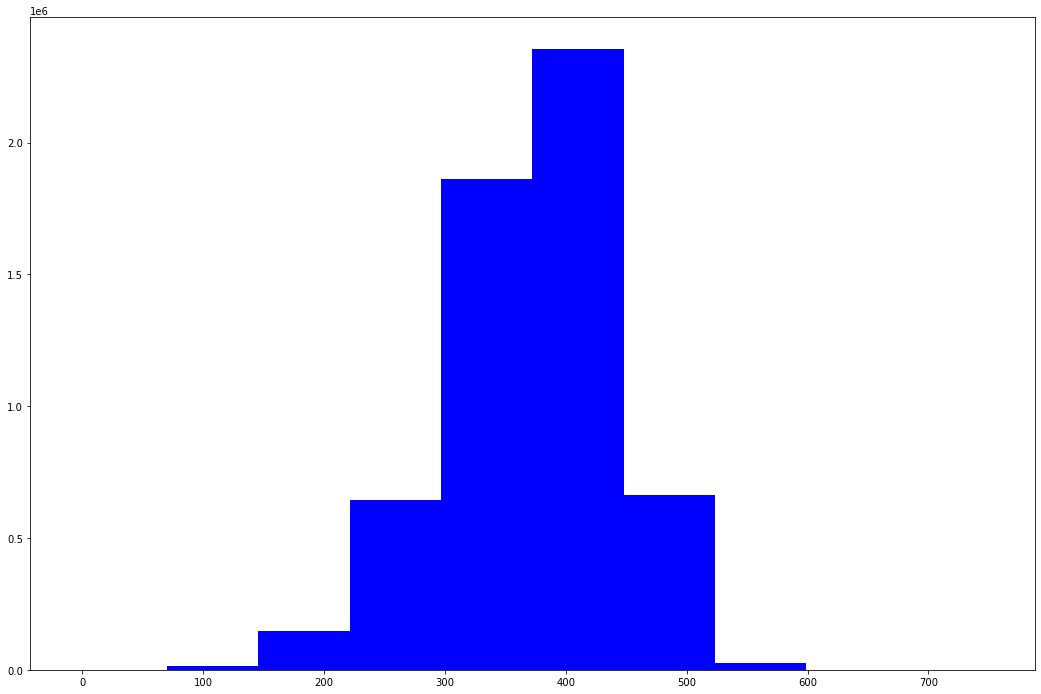

In [60]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

def draw_histogram(rdd_histogram_data):
    height=np.array(rdd_histogram_data[1])
    full_bins = rdd_histogram_data[0]
    mid_point_bins = full_bins[:-1]
    widths = [abs(i-j) for i, j in zip(full_bins[:-1], full_bins[1:])]
    bar = plt.bar(mid_point_bins, height, width=widths, color='b')
    return bar

departure_delay_histogram = mph.select("Mph").rdd.flatMap(lambda x:x).histogram(10)
draw_histogram(departure_delay_histogram)

<BarContainer object of 20 artists>

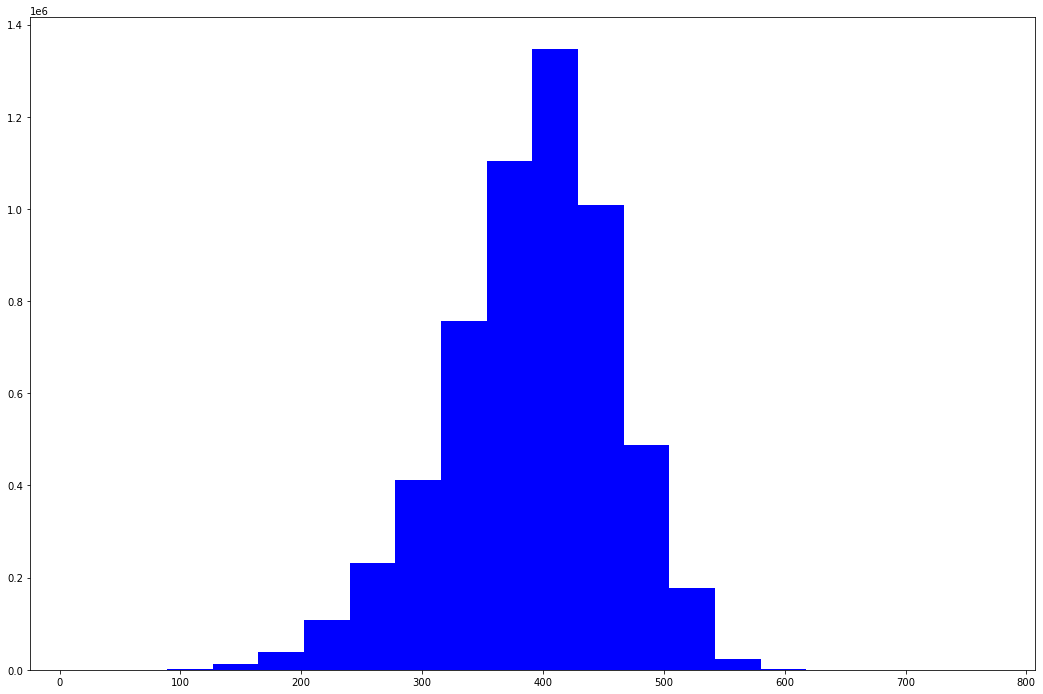

In [61]:
departure_delay_histogram = mph.select("Mph").rdd.flatMap(lambda x:x).histogram(20)
draw_histogram(departure_delay_histogram)

In [62]:
tail_numbers = on_time_df.rdd.map(lambda x:x.TailNum).filter(lambda x:x!='' and x is not None)
unique_tail_numbers = tail_numbers.distinct()
airplane_count = unique_tail_numbers.count()
print(f"Total Airplanes: {airplane_count}")

Total Airplanes: 4897


In [63]:
origin_hour_dist = on_time_df.filter(on_time_df.AirTime.isNotNull()).select("Origin", (on_time_df.AirTime/60).alias("Hours"), "Distance")
mph_origins = origin_hour_dist.select("Origin", (origin_hour_dist.Distance/origin_hour_dist.Hours).alias("Mph"))
mph_origins.registerTempTable("mph_origins")
avg_speeds = mph_origins.groupBy("Origin").agg({"Mph":"avg"}).alias("Mph")
avg_speeds.show()

+------+------------------+
|Origin|          avg(Mph)|
+------+------------------+
|   BGM| 346.1853538898441|
|   PSE|452.61176800000527|
|   INL|286.26851316932084|
|   MSY|417.88066171277154|
|   PPG| 504.2422916767315|
|   GEG|402.28558929054554|
|   SNA|  417.168769940005|
|   BUR| 381.5411358971755|
|   GRB| 304.8341806425377|
|   GTF|425.33903080533736|
|   IDA|352.21033421102845|
|   GRR|345.74023303402765|
|   JLN| 333.8980691779108|
|   PSG|218.63993665683003|
|   EUG| 408.3697364617108|
|   PVD| 377.2849336122921|
|   GSO|363.15998763789804|
|   MYR|392.41545245530193|
|   OAK| 411.1720814918371|
|   MSN| 328.7109364653059|
+------+------------------+
only showing top 20 rows



In [64]:
on_time_df.columns

['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'FlightDate',
 'Carrier',
 'TailNum',
 'FlightNum',
 'Origin',
 'OriginCityName',
 'OriginState',
 'Dest',
 'DestCityName',
 'DestState',
 'DepTime',
 'DepDelay',
 'DepDelayMinutes',
 'TaxiOut',
 'TaxiIn',
 'WheelsOff',
 'WheelsOn',
 'ArrTime',
 'ArrDelay',
 'ArrDelayMinutes',
 'Cancelled',
 'Diverted',
 'ActualElapsedTime',
 'AirTime',
 'Flights',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'CRSDepTime',
 'CRSArrTime']

In [65]:
on_time_df.groupBy("Origin").avg().show(1)
on_time_df.groupBy("Origin").agg({"AirTime":"mean"}).show(1)
on_time_df.groupBy("Origin").count().show(1)
on_time_df.groupBy("Origin").agg({"AirTime":"max"}).show(1)
on_time_df.groupBy("Origin").max().show(1)
on_time_df.groupBy("Origin").agg({"AirTime":"min"}).show(1)
on_time_df.groupBy("Origin").agg({"AirTime":"sum"}).show(1)

+------+----------------+--------------------+------------------+---------------+-----------------+--------------------+--------------------+-------------+----------------------+-----------------+------------+-------------+-----------------+-----------------+------------------+--------------------+----------------------+
|Origin|   avg(DepDelay)|avg(DepDelayMinutes)|      avg(TaxiOut)|    avg(TaxiIn)|    avg(ArrDelay)|avg(ArrDelayMinutes)|      avg(Cancelled)|avg(Diverted)|avg(ActualElapsedTime)|     avg(AirTime)|avg(Flights)|avg(Distance)|avg(CarrierDelay)|avg(WeatherDelay)|     avg(NASDelay)|  avg(SecurityDelay)|avg(LateAircraftDelay)|
+------+----------------+--------------------+------------------+---------------+-----------------+--------------------+--------------------+-------------+----------------------+-----------------+------------+-------------+-----------------+-----------------+------------------+--------------------+----------------------+
|   BGM|9.42056074766355|  15.1

+------+-----------------+
|Origin|     avg(AirTime)|
+------+-----------------+
|   BGM|66.00934579439253|
+------+-----------------+
only showing top 1 row



+------+-----+
|Origin|count|
+------+-----+
|   BGM|  324|
+------+-----+
only showing top 1 row



+------+------------+
|Origin|max(AirTime)|
+------+------------+
|   BGM|        91.0|
+------+------------+
only showing top 1 row



+------+-------------+--------------------+------------+-----------+-------------+--------------------+--------------+-------------+----------------------+------------+------------+-------------+-----------------+-----------------+-------------+------------------+----------------------+
|Origin|max(DepDelay)|max(DepDelayMinutes)|max(TaxiOut)|max(TaxiIn)|max(ArrDelay)|max(ArrDelayMinutes)|max(Cancelled)|max(Diverted)|max(ActualElapsedTime)|max(AirTime)|max(Flights)|max(Distance)|max(CarrierDelay)|max(WeatherDelay)|max(NASDelay)|max(SecurityDelay)|max(LateAircraftDelay)|
+------+-------------+--------------------+------------+-----------+-------------+--------------------+--------------+-------------+----------------------+------------+------------+-------------+-----------------+-----------------+-------------+------------------+----------------------+
|   BGM|        993.0|                 993|       100.0|       30.0|       1005.0|              1005.0|             1|            0|    

+------+------------+
|Origin|min(AirTime)|
+------+------------+
|   BGM|        56.0|
+------+------------+
only showing top 1 row



+------+------------+
|Origin|sum(AirTime)|
+------+------------+
|   BGM|     21189.0|
+------+------------+
only showing top 1 row



In [66]:
on_time_df.filter("Origin == 'ATL'").groupBy("Origin").pivot("Dest").avg("AirTime").rdd.map(lambda x:x.asDict()).collect()[0]

{'Origin': 'ATL',
 'ABE': 96.59897959183674,
 'ABQ': 172.1290684624018,
 'ABY': 29.252365930599368,
 'ACY': 90.23557692307692,
 'AEX': 78.87462235649546,
 'AGS': 29.076743280093496,
 'ALB': 108.65161923454367,
 'ANC': 426.3529411764706,
 'ASE': 198.09574468085106,
 'ATW': 105.11235955056179,
 'AUS': 117.13764946048411,
 'AVL': 33.510327455919395,
 'AVP': 93.94900849858357,
 'AZO': 86.6842105263158,
 'BDL': 109.44785031847134,
 'BHM': 28.848588537211292,
 'BMI': 78.14963119072708,
 'BNA': 38.880419382261266,
 'BOS': 120.84425582313462,
 'BQK': 41.63483735571878,
 'BTR': 70.18819188191883,
 'BTV': 119.43465045592706,
 'BUF': 93.706432748538,
 'BWI': 81.02321908071394,
 'BZN': 220.15625,
 'CAE': 33.79744210162461,
 'CAK': 72.89645776566758,
 'CHA': 24.022727272727273,
 'CHO': 66.9613478691774,
 'CHS': 42.49556255367879,
 'CID': 101.25268817204301,
 'CLE': 77.47449470644851,
 'CLT': 41.581799591002046,
 'CMH': 66.05350605463249,
 'COS': 161.14626865671642,
 'CRW': 57.365990202939116,
 'CSG

In [67]:
mph = spark.sql("""
SELECT Distance, (Distance/(AirTime/60)) AS Mph
FROM on_time_performance
WHERE AirTime IS NOT NULL
""")
mph.show(10)

+--------+------------------+
|Distance|               Mph|
+--------+------------------+
|   432.0| 439.3220338983051|
|   432.0| 336.6233766233766|
|   802.0| 373.0232558139535|
|   731.0|471.61290322580646|
|   769.0| 415.6756756756757|
|   769.0|427.22222222222223|
|  1047.0| 430.2739726027398|
|   731.0| 359.5081967213115|
|   731.0|466.59574468085106|
|   731.0|  481.978021978022|
+--------+------------------+
only showing top 10 rows



In [68]:
distance = mph.select("Distance").rdd.flatMap(lambda x:x)
distance = distance.collect()
distance[0:10]

[432.0, 432.0, 802.0, 731.0, 769.0, 769.0, 1047.0, 731.0, 731.0, 731.0]

In [69]:
speed = mph.select("Mph").rdd.flatMap(lambda x:x)
speed = speed.collect()
speed[0:10]

[439.3220338983051,
 336.6233766233766,
 373.0232558139535,
 471.61290322580646,
 415.6756756756757,
 427.22222222222223,
 430.2739726027398,
 359.5081967213115,
 466.59574468085106,
 481.978021978022]

In [70]:
print(f"Total distance: {len(distance)}")
print(f"Total speeds: {len(speed)}")

Total distance: 5714008
Total speeds: 5714008


In [71]:
sample = mph.sample(False, 0.001)
sample.count()

5768

In [72]:
speed = sample.select("Mph").rdd.flatMap(lambda x:x).collect()
distance = sample.select("Distance").rdd.flatMap(lambda x:x).collect()
print(f"{len(speed)} x {len(distance)} records")

5768 x 5768 records


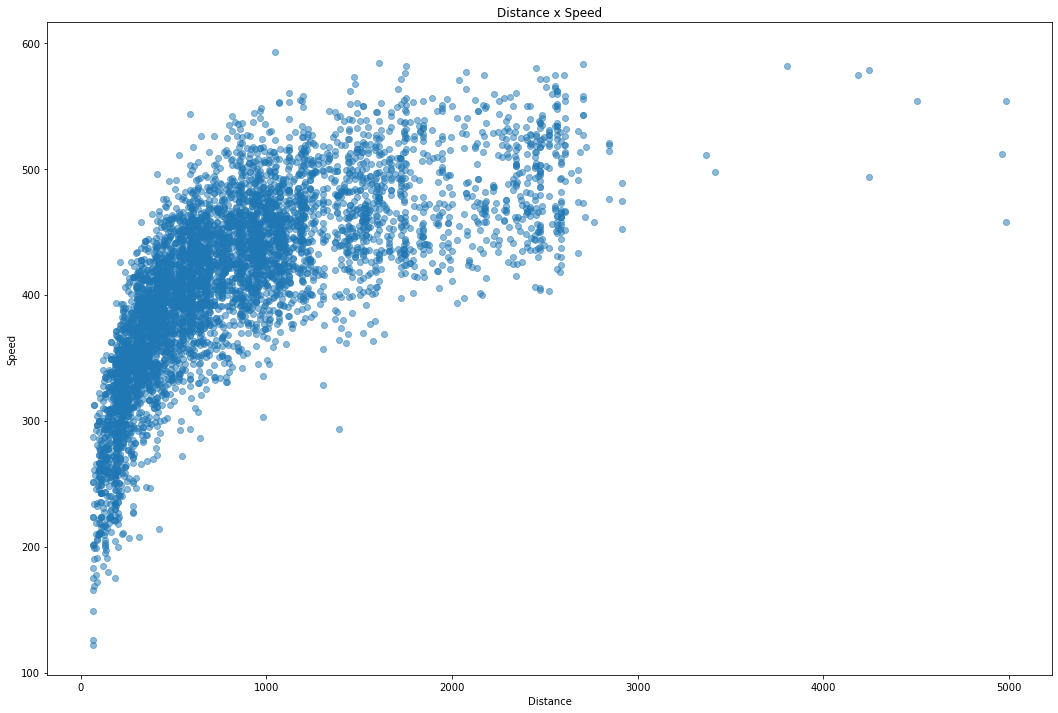

In [73]:
import numpy as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 12)
plt.scatter(distance, speed, alpha=0.5)
plt.title("Distance x Speed")
plt.xlabel("Distance")
plt.ylabel("Speed")
plt.show()

Excercise
- Query the on_time_dataframe to focus on two numeric fields.
- Plot a histogram of one of these fields
- Plot a scatterplot of both of these fields

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

x=np.array(distance)
y=np.array(speed)
x_test = np.arange(0, 5000, 100)
model = Pipeline([('ploy', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(x[:, np.newaxis], y)
model.named_steps['linear'].coef_
y_out = model.predict(x_test.reshape(-1, 1))
cross_val_score(model, x.reshape(-1, 1), y)

array([0.60304948, 0.63059965, 0.72203986, 0.70360977, 0.62397214])

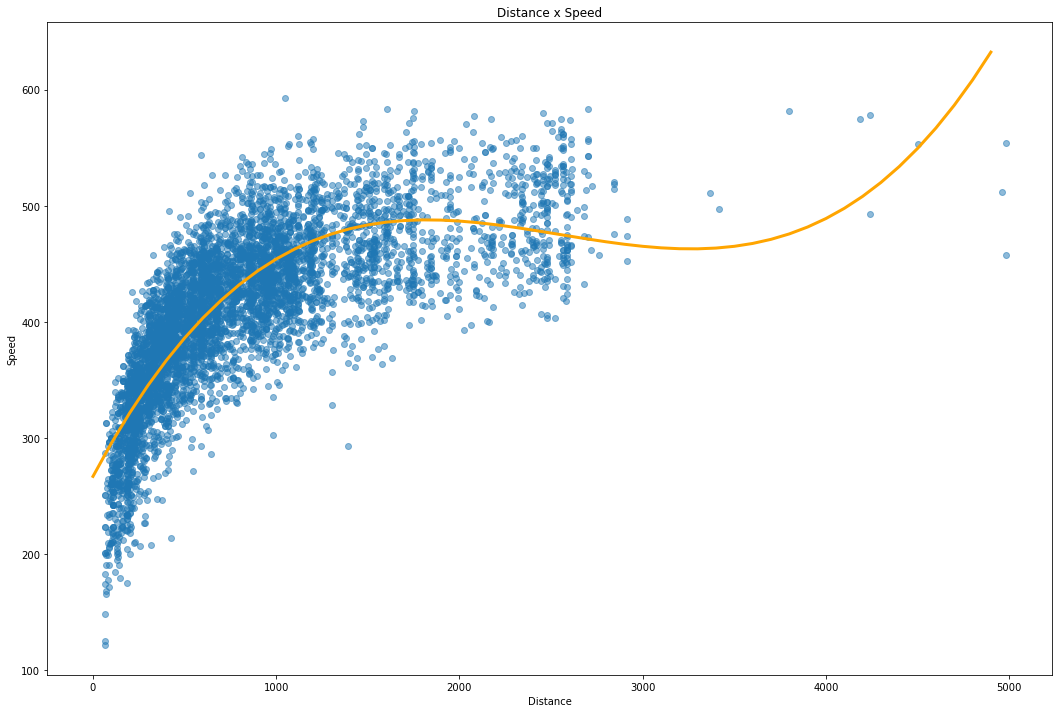

In [75]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=(18, 12)
plt.scatter(distance, speed, alpha=0.5)
plt.plot(x_test, y_out, color='orange', linewidth=3)
plt.title("Distance x Speed")
plt.xlabel("Distance")
plt.ylabel("Speed")
plt.show()

In [76]:
tail_numbers = on_time_df.select("TailNum").distinct()
tail_numbers.show(6)

+-------+
|TailNum|
+-------+
| N396AA|
| N3CWAA|
| N499AA|
| N4YUAA|
| N567AA|
| N442AS|
+-------+
only showing top 6 rows



In [77]:
faa_tail_number_inquiry = spark.read.json('data/faa_tail_number_inquiry.jsonl')
airplane_records = faa_tail_number_inquiry.select(
    faa_tail_number_inquiry.TailNum.alias("FAATailNum"), "Model", "Engine_Model")
airplane_records.show(6)

+----------+-----------+------------+
|FAATailNum|      Model|Engine_Model|
+----------+-----------+------------+
|    N933EV|CL-600-2B19| CF34 SERIES|
|    N917WN|    737-7H4|  CFM56-7B24|
|    N438WN|    737-7H4|CFM56 SERIES|
|    N283VA|   A320-214| CFM56-5B4/3|
|    N473UA|   A320-232| AL-25SERIES|
|    N637JB|   A320-232|    V2527-A5|
+----------+-----------+------------+
only showing top 6 rows



In [78]:
print(f"FAA tail number: {tail_numbers.count()}")
print(f"Airplane records: {airplane_records.count()}")
inner_joined = tail_numbers.join(airplane_records, tail_numbers.TailNum == airplane_records.FAATailNum, "inner")
print(f"Joined records: {inner_joined.count()}")

FAA tail number: 4898
Airplane records: 3988


Joined records: 3988


In [79]:
inner_joined.show(6)

+-------+----------+--------------+------------+
|TailNum|FAATailNum|         Model|Engine_Model|
+-------+----------+--------------+------------+
| N396AA|    N396AA|          B300|    PT6A SER|
| N499AA|    N499AA|DC-9-82(MD-82)| JT8D SERIES|
| N442AS|    N442AS|     737-990ER| CFM56-7B27E|
| N369NB|    N369NB|      A319-114|CFM56 SERIES|
| N388DA|    N388DA|       737-832|CFM56 SERIES|
|  N6700|     N6700|       757-232|      PW2037|
+-------+----------+--------------+------------+
only showing top 6 rows



In [80]:
print(f"FAA tail numbers: {tail_numbers.count()}")
print(f"Airplane records: {airplane_records.count()}")
left_outer_joined = tail_numbers.join(airplane_records, tail_numbers.TailNum == airplane_records.FAATailNum, 'left_outer')
print(f"Joined records: {left_outer_joined.count()}")

FAA tail numbers: 4898
Airplane records: 3988


Joined records: 4898


In [81]:
left_outer_joined.show(6)

+-------+----------+--------------+------------+
|TailNum|FAATailNum|         Model|Engine_Model|
+-------+----------+--------------+------------+
| N396AA|    N396AA|          B300|    PT6A SER|
| N3CWAA|      null|          null|        null|
| N499AA|    N499AA|DC-9-82(MD-82)| JT8D SERIES|
| N4YUAA|      null|          null|        null|
| N567AA|      null|          null|        null|
| N442AS|    N442AS|     737-990ER| CFM56-7B27E|
+-------+----------+--------------+------------+
only showing top 6 rows



Exercise

In [82]:
flights = on_time_df.rdd.map(lambda x:(x.Carrier, x.FlightDate, x.FlightNum, x.Origin, x.Dest, x.TailNum))

flights_per_airplane = flights.map(lambda nameTuple:(nameTuple[5], [nameTuple[0:5]]))\
.reduceByKey(lambda a, b:a+b).map(lambda tuple:
                                  {
                                      'TailNum':tuple[0],
                                      'Flights':sorted(tuple[1], key=lambda x:(x[1], x[2], x[3], x[4]))
                                  }
                                 )
flights_per_airplane.first()

{'TailNum': 'N549UW',
 'Flights': [('US', '2015-01-01', '1711', 'CLT', 'EWR'),
  ('US', '2015-01-01', '1711', 'TPA', 'CLT'),
  ('US', '2015-01-01', '1808', 'ATL', 'CLT'),
  ('US', '2015-01-01', '1808', 'CLT', 'TPA'),
  ('US', '2015-01-02', '1729', 'CLT', 'MCO'),
  ('US', '2015-01-02', '1729', 'EWR', 'CLT'),
  ('US', '2015-01-02', '2029', 'CLT', 'SFO'),
  ('US', '2015-01-02', '2029', 'MCO', 'CLT'),
  ('US', '2015-01-02', '2029', 'SFO', 'PHX'),
  ('US', '2015-01-03', '1853', 'ATL', 'PHX'),
  ('US', '2015-01-03', '1853', 'PHX', 'LAS'),
  ('US', '2015-01-03', '2011', 'MSP', 'PHX'),
  ('US', '2015-01-03', '2011', 'PHX', 'LAX'),
  ('US', '2015-01-03', '417', 'PHX', 'ATL'),
  ('US', '2015-01-03', '473', 'LAS', 'PHX'),
  ('US', '2015-01-03', '473', 'PHX', 'MSP'),
  ('US', '2015-01-04', '598', 'LAX', 'PHL'),
  ('US', '2015-01-04', '755', 'PHL', 'LAX'),
  ('US', '2015-01-05', '499', 'CLT', 'DEN'),
  ('US', '2015-01-05', '499', 'MIA', 'CLT'),
  ('US', '2015-01-05', '761', 'CLT', 'MIA'),
  ('US', 

In [83]:
total_flights = on_time_df.count()
print(f"total flights: {total_flights}")
late_departs = on_time_df.filter(on_time_df.DepDelayMinutes>0)
total_late_departs = late_departs.count()
print(f"late departures: {total_late_departs}")
late_arrivals = on_time_df.filter(on_time_df.ArrDelayMinutes>0)
total_late_arrivals = late_arrivals.count()
print(f"late arrivals: {total_late_arrivals}")
pct_late = (total_late_arrivals/total_flights)*100
pct_late

total flights: 5819079
late departures: 2125618
late arrivals: 2086896


35.8629948141278

In [84]:
on_time_heros = on_time_df.filter((on_time_df.DepDelayMinutes>0)&(on_time_df.ArrDelayMinutes<=0))
total_on_time_hereos = on_time_heros.count()
print(f"total on time heros: {total_on_time_hereos}")

total on time heros: 606902


In [85]:
spark.sql("""
SELECT
  ROUND(AVG(DepDelay),1) AS AvgDepDelay,
  ROUND(AVG(ArrDelay),1) AS AvgArrDelay
FROM on_time_performance
""").show()

+-----------+-----------+
|AvgDepDelay|AvgArrDelay|
+-----------+-----------+
|        9.4|        4.4|
+-----------+-----------+



In [86]:
late_flights = spark.sql("""
SELECT
  ArrDelayMinutes,
  WeatherDelay,
  CarrierDelay,
  NASDelay,
  SecurityDelay,
  LateAircraftDelay
FROM
  on_time_performance
WHERE
  WeatherDelay IS NOT NULL
  OR
  CarrierDelay IS NOT NULL
  OR
  NASDelay IS NOT NULL
  OR
  SecurityDelay IS NOT NULL
  OR
  LateAircraftDelay IS NOT NULL
ORDER BY
  FlightDate
""")
late_flights.sample(False, 0.01).show()

+---------------+------------+------------+--------+-------------+-----------------+
|ArrDelayMinutes|WeatherDelay|CarrierDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+---------------+------------+------------+--------+-------------+-----------------+
|           21.0|         0.0|         0.0|     0.0|          0.0|             21.0|
|           83.0|         0.0|        67.0|     6.0|          0.0|             10.0|
|          114.0|         0.0|         0.0|    16.0|          0.0|             98.0|
|          102.0|         0.0|         6.0|     0.0|          0.0|             96.0|
|           22.0|         0.0|         8.0|     9.0|          0.0|              5.0|
|           17.0|         0.0|         0.0|    17.0|          0.0|              0.0|
|           53.0|         0.0|         0.0|     0.0|          0.0|             53.0|
|           32.0|         0.0|        20.0|     9.0|          0.0|              3.0|
|           60.0|         0.0|        60.0|     0.0|          0.0

In [87]:
total_delays = spark.sql("""
SELECT
  ROUND(SUM(WeatherDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_weather_delay,
  ROUND(SUM(CarrierDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_carrier_delay,
  ROUND(SUM(NASDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_nas_delay,
  ROUND(SUM(SecurityDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_security_delay,
  ROUND(SUM(LateAircraftDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_late_aircraft_delay
FROM on_time_performance
""")
total_delays.show()

+-----------------+-----------------+-------------+------------------+-----------------------+
|pct_weather_delay|pct_carrier_delay|pct_nas_delay|pct_security_delay|pct_late_aircraft_delay|
+-----------------+-----------------+-------------+------------------+-----------------------+
|              4.5|             29.2|         20.7|               0.1|                   36.1|
+-----------------+-----------------+-------------+------------------+-----------------------+



In [88]:
weather_delay_histogram = on_time_df.select("WeatherDelay").rdd.flatMap(lambda x:x)\
.histogram([1, 5, 10, 15, 30, 60, 120, 240, 480, 720, 24*60])
print(weather_delay_histogram)

([1, 5, 10, 15, 30, 60, 120, 240, 480, 720, 1440], [5436, 7668, 6636, 16007, 13569, 9442, 4598, 1136, 152, 72])


<BarContainer object of 10 artists>

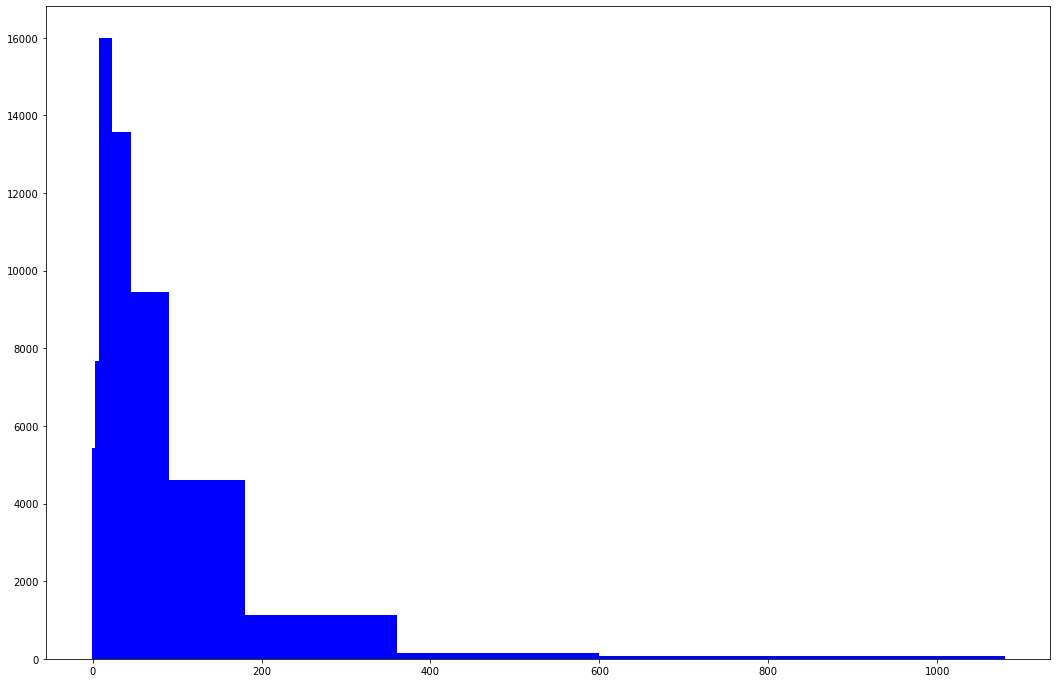

In [89]:
draw_histogram(weather_delay_histogram)

In [90]:
def histogram_to_publishable(histogram):
    record = {'key':1, 'data':[]}
    for label, value in zip(histogram[0], histogram[1]):
        record['data'].append({'label':label, 'value':value})
    return record


weather_delay_histogram = on_time_df.filter((on_time_df.WeatherDelay.isNotNull())&(on_time_df.WeatherDelay>0))\
.select("WeatherDelay").rdd.flatMap(lambda x:x).histogram([0,5,15,30,60, 120,240, 480, 720, 24*60])
print(weather_delay_histogram)

record = histogram_to_publishable(weather_delay_histogram)
record

([0, 5, 15, 30, 60, 120, 240, 480, 720, 1440], [5436, 14304, 16007, 13569, 9442, 4598, 1136, 152, 72])


{'key': 1,
 'data': [{'label': 0, 'value': 5436},
  {'label': 5, 'value': 14304},
  {'label': 15, 'value': 16007},
  {'label': 30, 'value': 13569},
  {'label': 60, 'value': 9442},
  {'label': 120, 'value': 4598},
  {'label': 240, 'value': 1136},
  {'label': 480, 'value': 152},
  {'label': 720, 'value': 72}]}

In [91]:
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DateType, TimestampType
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import udf

schema = StructType([
  StructField("ArrDelay", DoubleType(), True),     # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True),    # "CRSArrTime":"2015-12-31T03:20:00.000-08:00"
  StructField("CRSDepTime", TimestampType(), True),    # "CRSDepTime":"2015-12-31T03:05:00.000-08:00"
  StructField("Carrier", StringType(), True),     # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True), # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),  # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),  # "DayOfYear":365
  StructField("DepDelay", DoubleType(), True),     # "DepDelay":14.0
  StructField("Dest", StringType(), True),        # "Dest":"SAN"
  StructField("Distance", DoubleType(), True),     # "Distance":368.0
  StructField("FlightDate", DateType(), True),    # "FlightDate":"2015-12-30T16:00:00.000-08:00"
  StructField("FlightNum", StringType(), True),   # "FlightNum":"6109"
  StructField("Origin", StringType(), True),      # "Origin":"TUS"
])

features = spark.read.json("data/simple_flight_delay_features.jsonl.bz2", schema=schema)
features.first()

Row(ArrDelay=13.0, CRSArrTime=datetime.datetime(2015, 1, 2, 3, 10), CRSDepTime=datetime.datetime(2015, 1, 2, 0, 30), Carrier='AA', DayOfMonth=1, DayOfWeek=4, DayOfYear=1, DepDelay=14.0, Dest='DFW', Distance=569.0, FlightDate=datetime.date(2015, 1, 1), FlightNum='1024', Origin='ABQ')

In [92]:
null_counts = [(column, features.where(features[column].isNull()).count()) for column in features.columns]
cols_with_nulls = filter(lambda x: x[1]>0, null_counts)
print(list(cols_with_nulls))

[]


In [93]:
from pyspark.sql.functions import lit, concat

features_with_route = features.withColumn('Route', concat(features.Origin, lit('-'), features.Dest))
features_with_route.select("Origin", "Dest", "Route").show(10)

+------+----+-------+
|Origin|Dest|  Route|
+------+----+-------+
|   ABQ| DFW|ABQ-DFW|
|   ABQ| DFW|ABQ-DFW|
|   ABQ| DFW|ABQ-DFW|
|   ATL| DFW|ATL-DFW|
|   ATL| DFW|ATL-DFW|
|   ATL| DFW|ATL-DFW|
|   ATL| DFW|ATL-DFW|
|   ATL| DFW|ATL-DFW|
|   ATL| DFW|ATL-DFW|
|   ATL| DFW|ATL-DFW|
+------+----+-------+
only showing top 10 rows



In [94]:
from pyspark.ml.feature import Bucketizer

splits = [-float("inf"), -15.0, 0, 30.0, float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="ArrDelay", outputCol="ArrDelayBucket")
ml_bk_features = bucketizer.transform(features_with_route)

ml_bk_features.select("ArrDelay", "ArrDelayBucket").show()

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|    13.0|           2.0|
|    17.0|           2.0|
|    36.0|           3.0|
|   -21.0|           0.0|
|   -14.0|           1.0|
|    16.0|           2.0|
|    -7.0|           1.0|
|    13.0|           2.0|
|    25.0|           2.0|
|    58.0|           3.0|
|    14.0|           2.0|
|     1.0|           2.0|
|   -29.0|           0.0|
|   -10.0|           1.0|
|    -3.0|           1.0|
|    -8.0|           1.0|
|    -1.0|           1.0|
|   -14.0|           1.0|
|   -16.0|           0.0|
|    18.0|           2.0|
+--------+--------------+
only showing top 20 rows



In [96]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

for col in ["Carrier", "DayOfMonth", "DayOfWeek", "DayOfYear", "Origin", "Dest", "Route"]:
    string_indexer = StringIndexer(inputCol = col, outputCol=col+"_index")
    ml_bk_features = string_indexer.fit(ml_bk_features).transform(ml_bk_features)
    
    ml_bk_features.show(10)

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+
|    13.0|2015-01-02 03:10:00|2015-01-02 00:30:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1024|   ABQ|ABQ-DFW|           2.0|          4.0|
|    17.0|2015-01-01 19:15:00|2015-01-01 16:25:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1184|   ABQ|ABQ-DFW|           2.0|          4.0|
|    36.0|2015-01-01 20:45:00|2015-01-01 18:00:00|     AA|         1|        4|        1|    -2.0| DFW|   569.

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+
|    13.0|2015-01-02 03:10:00|2015-01-02 00:30:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1024|   ABQ|ABQ-DFW|           2.0|          4.0|            25.0|
|    17.0|2015-01-01 19:15:00|2015-01-01 16:25:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1184|   ABQ|ABQ-DFW|           2.0|          4.0|            25.0|
|    36.0|2015-01-01 20:4

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+
|    13.0|2015-01-02 03:10:00|2015-01-02 00:30:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1024|   ABQ|ABQ-DFW|           2.0|          4.0|            25.0|            1.0|
|    17.0|2015-01-01 19:15:00|2015-01-01 16:25:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1184|   ABQ|ABQ-DFW|        

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|DayOfYear_index|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+
|    13.0|2015-01-02 03:10:00|2015-01-02 00:30:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1024|   ABQ|ABQ-DFW|           2.0|          4.0|            25.0|            1.0|           25.0|
|    17.0|2015-01-01 19:15:00|2015-01-01 16:25:00|     AA|         1|        4|        1|   

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|DayOfYear_index|Origin_index|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+
|    13.0|2015-01-02 03:10:00|2015-01-02 00:30:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1024|   ABQ|ABQ-DFW|           2.0|          4.0|            25.0|            1.0|           25.0|        56.0|
|    17.0|2015-01-01 19:15:00|2015-01-01

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|DayOfYear_index|Origin_index|Dest_index|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+
|    13.0|2015-01-02 03:10:00|2015-01-02 00:30:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1024|   ABQ|ABQ-DFW|           2.0|          4.0|            25.0|            1.0|           25.0|        56.0|       1

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|DayOfYear_index|Origin_index|Dest_index|Route_index|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|    13.0|2015-01-02 03:10:00|2015-01-02 00:30:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1024|   ABQ|ABQ-DFW|           2.0|          4.0|            25.0|            1.0| 

In [101]:
numeric_cols = ["DepDelay", "Distance"]
index_cols = ["Carrier_index", "DayOfMonth_index",
              "DayOfWeek_index", "DayOfYear_index", "Origin_index",
              "Origin_index", "Dest_index", "Route_index"]
vector_assembler = VectorAssembler(inputCols=numeric_cols+index_cols,
                                   outputCol="Features_vec")
final_vectorized_features = vector_assembler.transform(ml_bk_features)
for col in index_cols:
    final_vectorized_features = final_vectorized_features.drop(col)
    
final_vectorized_features.show()

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|    13.0|2015-01-02 03:10:00|2015-01-02 00:30:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1024|   ABQ|ABQ-DFW|           2.0|[14.0,569.0,4.0,2...|
|    17.0|2015-01-01 19:15:00|2015-01-01 16:25:00|     AA|         1|        4|        1|    14.0| DFW|   569.0|2015-01-01|     1184|   ABQ|ABQ-DFW|           2.0|[14.0,569.0,4.0,2...|
|    36.0|2015-01-01 20:45:00|2015-01-01 18:00:00|     AA|         1|      

In [104]:
train_data, test_data = final_vectorized_features.randomSplit([0.7, 0.3])

from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(featuresCol="Features_vec",
                             labelCol="ArrDelayBucket",
                             maxBins=4657,
                             maxMemoryInMB=1024)
model = rfc.fit(train_data)

predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="ArrDelayBucket", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy = {accuracy}")

predictions.sample(False, 0.001, 18).orderBy("CRSDepTime").show(6)

Accuracy = 0.585480008177809


+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|       rawPrediction|         probability|prediction|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|    13.0|2015-01-01 23:55:00|2015-01-01 22:25:00|     WN|         1|        4|        1|    19.0| PDX|   479.0|2015-01-01|      267|   SMF|SMF-PDX|           2.0|[19.0,479.0,0.0,2...|[0.94936059183558...|[0.04746802959177...|       2.0|
|    -2.0|2015-01-02 01:20:00|2015-01-01 22:45:0